In [ ]:
# Retrieves processed data from Yoo-Jung and makes simple calibration

In [1]:
#from astropy.io import fits
import numpy as np
#import glob
#import os
import pickle
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits
#from scipy.optimize import curve_fit

from photutils.centroids import (centroid_1dg, centroid_2dg,
                                 centroid_com, centroid_quadratic)

%matplotlib inline

In [2]:
# gaussian profile
def gaus1d(x_pass, mu_pass, sigma_pass):
    
    return (1./(sigma_pass*np.sqrt(2.*np.pi))) * np.exp(-0.5 * np.power((x_pass-mu_pass)/sigma_pass,2.) )

In [3]:
# retrieve processed data arrays from pickle files

# single fiber
file = open('yoo_jung_single.pkl', 'rb')
dict_single = pickle.load(file)
file.close()

# 3 photonic lantern
file = open('yoo_jung_3PL.pkl', 'rb')
dict_3PL = pickle.load(file)
file.close()

# broadband image
file = open('yoo_jung_broadband.pkl', 'rb')
dict_broadband = pickle.load(file)
file.close()

In [4]:
# Yoo-Jung's spectrum (not the broadband one)

hdul = fits.open('./data/stacked.fits')
test_data = hdul[0].data

In [5]:
# retrieve wavelength soln

file = open('wavel_soln.pkl', 'rb')
fit_coeffs = pickle.load(file)
file.close()

In [6]:
def func(X, a, b, c, d, f):
    
    x_pass, y_pass = X
    
    return a*x_pass + b*y_pass + c*x_pass*y_pass + d*np.power(x_pass,2.) + f*np.power(y_pass,2.)

In [7]:
# get frames into a single cube

# initialize
cube_frames = np.zeros((np.shape(dict_single['1100'])[0],np.shape(dict_single['1100'])[1],len(dict_single)))

idx = 0

for key in dict_single:
    
    cube_frames[:,:,idx] = dict_single[key]
    
    idx += 1

In [8]:
# centroid the single fiber images

dict_centroids = {}

for key in dict_single:
    
    #print(value)
    
    this_slice = dict_single[key]
    
    # ersatz bad pixel mask
    this_slice[0:125,:] = 0
    this_slice[140:,:] = 0
    
    #x1, y1 = centroid_1dg(this_slice)
    #x2, y2 = centroid_2dg(this_slice)
    x3, y3 = centroid_com(this_slice)
    x4, y4 = centroid_quadratic(this_slice)
    
    dict_centroids[key] = (x4,y4)
    
    #plt.imshow(dict_single[key], origin='lower')
    #plt.scatter(x1, y1, color='white')
    #plt.scatter(x2, y2, color='blue')
    #plt.scatter(x3, y3, color='yellow')
    #plt.scatter(x4, y4, color='red')
    #plt.show()

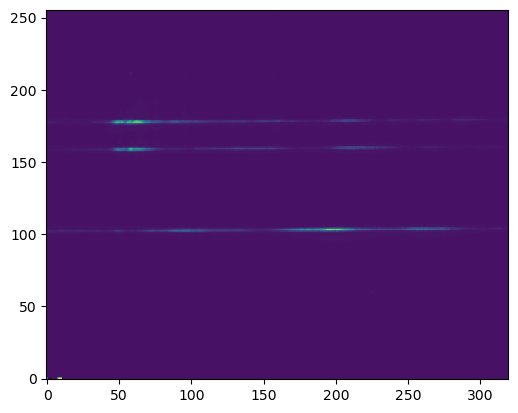

In [9]:
plt.imshow(test_data[0,:,:], vmin=0, vmax=20000, origin='lower')
plt.savefig('junk_3spec.png')

In [19]:
# fit an extended Gaussian to the broadband image

#array_broadband = dict_broadband['broadband']
array_broadband = test_data[0,:,:]

# ersatz bad pixel mask
y_center = 104 # 179 #104 # 179 # 160
array_broadband[0:y_center-4,:] = 0
array_broadband[y_center+4:,:] = 0

# normalize
array_broadband = np.divide(array_broadband,np.nanmax(array_broadband))

/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_19411/3573714240.py:12: RuntimeWarning: invalid value encountered in divide
  array_broadband = np.divide(array_broadband,np.nanmax(array_broadband))


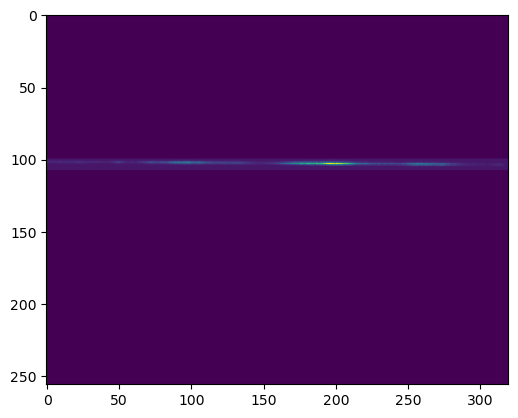

In [12]:
plt.imshow(array_broadband)
plt.show()

In [13]:
# ersatz variance array

array_variance = 1./np.add(array_broadband,0.001) # np.std(cube_bad,axis=2)**2

In [14]:
# make the enclosing profile of the spectrum

array_profile = np.zeros(np.shape(array_broadband))
xgrid, ygrid = np.meshgrid(np.arange(0,np.shape(array_profile)[1]),np.arange(0,np.shape(array_profile)[0]))
array_profile = gaus1d(x_pass = ygrid, mu_pass = y_center, sigma_pass=1)

# normalize it such that the marginalization in x (in (x,lambda) space) is 1
# (with a perfect Gaussian profile in x this is redundant)
array_profile = np.divide(array_profile,np.sum(array_profile, axis=0))

In [15]:
# now we have (see Eqn. (8) in Horne 1986 PASP 98:609)
# 1. V: array_variance
# 2. P: array_profile
# 3. D-S: array_broadband
# renaming for clarity,
V = array_variance
P = array_profile
D_S = array_broadband

numera = np.sum( np.divide(np.multiply(P,D_S),V), axis = 0 )
denom = np.sum( np.divide(np.power(P,2.),V), axis = 0 )

In [16]:
# column of best-fit wavelength values

x = np.arange(np.shape(dict_single['1100'])[1]) # stand-in for now
y = y_center # stand-in for now

wavel_array = func((x,y), fit_coeffs[0][0], fit_coeffs[0][1], fit_coeffs[0][2], 
                                     fit_coeffs[0][3], fit_coeffs[0][4])

In [16]:
# retrieve Yoo-Jun's spectrum to compare

test = np.load('./data/20230428/noturb_0_0_apapane_spec.npy')

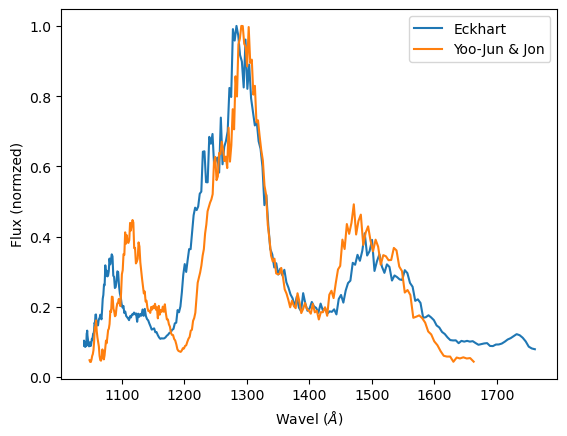

In [42]:
plt.plot(wavel_array,(numera/denom)/np.max(numera/denom), label='Eckhart')
plt.plot(test[0,:],test[1,:]/np.max(test[1,:]), label='Yoo-Jun & Jon')
plt.legend()
plt.xlabel('Wavel ($\AA$)')
plt.ylabel('Flux (normzed)')
plt.savefig('test1.png')

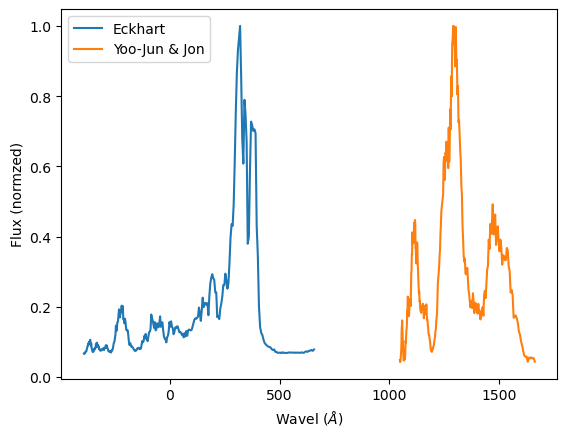

In [17]:
plt.plot(wavel_array,(numera/denom)/np.max(numera/denom), label='Eckhart')
plt.plot(test[0,:],test[1,:]/np.max(test[1,:]), label='Yoo-Jun & Jon')
plt.legend()
plt.xlabel('Wavel ($\AA$)')
plt.ylabel('Flux (normzed)')
plt.savefig('test1.png')

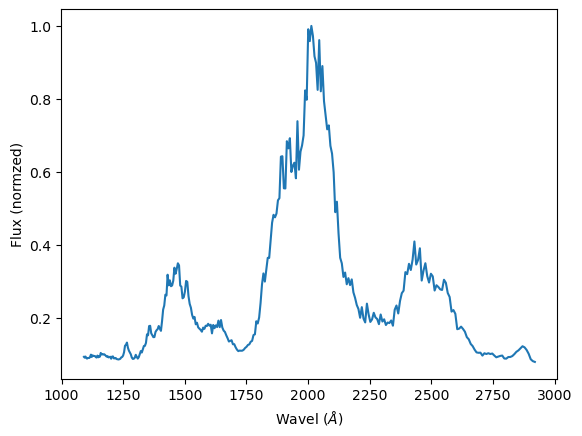

In [17]:
plt.clf()
plt.plot(wavel_array,(numera/denom)/np.max(numera/denom))
plt.xlabel('Wavel ($\AA$)')
plt.ylabel('Flux (normzed)')
plt.savefig('test1.png')

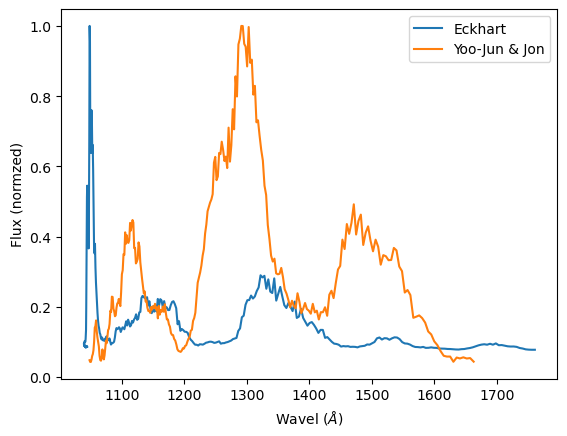

In [16]:
plt.plot(wavel_array,(numera/denom)/np.max(numera/denom), label='Eckhart')
plt.plot(test[0,:],test[1,:]/np.max(test[1,:]), label='Yoo-Jun & Jon')
plt.legend()
plt.xlabel('Wavel ($\AA$)')
plt.ylabel('Flux (normzed)')
plt.savefig('test1.png')

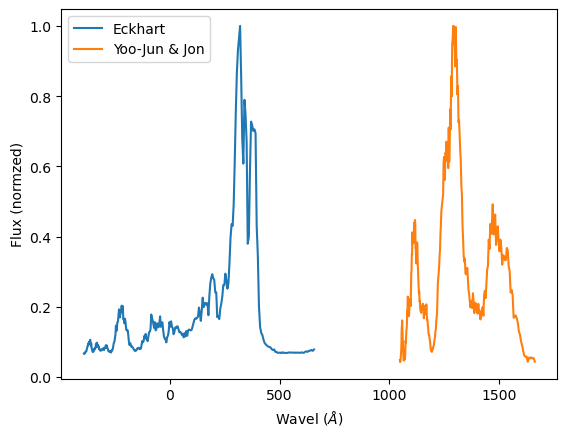

In [17]:
plt.plot(wavel_array,(numera/denom)/np.max(numera/denom), label='Eckhart')
plt.plot(test[0,:],test[1,:]/np.max(test[1,:]), label='Yoo-Jun & Jon')
plt.legend()
plt.xlabel('Wavel ($\AA$)')
plt.ylabel('Flux (normzed)')
plt.savefig('junk_test1.png')